The model we are hoping to build looks like: 

V_ij = eps_ij $*$ (V_ii $*$ e^(-i $*$ pi $*$ tau_ci $*$ nu) + V_jj $*$ e^(-i $*$ pi $*$  tau_cj $*$ nu)) 
        + P_ij * e^(-i * pi * tau_aij * nu) * (V_ii + V_jj)
        
        
The variables we are working with are: 

V_ij : the data averaged across time

        (getting the approx from: the data array for the combined and averaged uvfits files)

eps_ij : the amplitude of the signal traveling through cables

        (getting the approx from: the amplitude array from outside baseline dependence; shape is Nbls by Nfreqs)

V_ii, V_jj : the autocorrelation for each of the two antennas

P_ij : the amplitude of the signal traveling through the air

        (getting the approx from: the amplitude array within baseline dependence; shape is Nbls by Nfreqs)

tau_ci, tau_cj : the "cable" delays 

        (getting the approx from: a row or column of amplitude array averaged across frequency)

tau_aij : the air delay 
        
        (getting the approx from: baseline length in ns)

nu : the frequency

        (getting the approx from: the frequency array)      

In [1]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cmath

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light
c = 0.299792 * 1e9
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,84,98,136])

In [7]:
#Define antenna numbers 
antenna1 = 65
antenna2 = 68

In [2]:
# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')


#Read in the position and antenna numbers for all antennas
antpos, ants = uvxy.get_ENU_antpos()

#Create a dictionary which associates the antenna number with the indexing number in ants
ant_dict = {x: i for i,x in enumerate(ants)}

def find_bl_len(antnum1,antnum2):
    blin_length = 0
    #Step through each antenna pair 
    for aa,ant1 in enumerate(ants):
        for bb,ant2 in enumerate(ants):
            if (ant1 == antnum1 and ant2 == antnum2) or (ant2==antnum1 and ant1==antnum2):
                #Find the horizontal distance between the two antennas
                x = antpos[aa,0] - antpos[bb,0]
                #Find the vertical distance between the two antennas
                y = antpos[aa,1] - antpos[bb,1]
                #Find the hypotenus of the triangle, which is the total distance between
                #the two antennas
                diag = np.sqrt(x**2 + y**2)
                #Place this value into the array
                blin_length = diag
                return(blin_length)

We are going to focus on getting the spikes in the correct places. This is controlled by the exponential factors, so we are only going to worry about those. 

To form those exponential terms, we need tau_ci, tau_cj, tau_aij, and nu. 

In [3]:
#Build a matrix of baselines in ns
taus_a = np.zeros((len(ants),len(ants)))
for i, ant1 in enumerate(ants):
    for j, ant2 in enumerate(ants):
        taus_a[i,j] = find_bl_len(ant1,ant2) / c

print taus_a.shape
#Taus_a is in seconds
print np.mean(taus_a)

(52, 52)
1.89227120998671e-07


In [4]:
#Define frequency variable
nu = uvxy.freq_array 
print nu.shape
#Nu is in Hz, or 1/seconds
print np.mean(nu)

#Initialize array for autocorrs
#But I'm still confused and having difficulty with array shapes
V_k = np.zeros((len(ants),uvxy.Nfreqs),dtype='complex')
print V_k.shape

(1, 1024)
149951171.875
(52, 1024)


In [5]:
# Step through each antenna and find autocorr data
for i,ant1 in enumerate(uvxy.ant_2_array):
    ant2 = uvxy.ant_1_array[i]
    if (ant1==ant2):
        x = uvxy.data_array[i,0,:,0]
        V_k[ant_dict[ant1]] = x

In [7]:
#Checks and tests
print V_k.shape
print np.e**((-1j) * np.pi * taus_a[ant_dict[antenna1],ant_dict[antenna2]])
print V_k[ant_dict[13]][:].shape
print np.mean(V_k[ant_dict[antenna1]][:][:])

(52, 1024)
(1-4.59240630529e-07j)
(1024,)
(2.6368608972916263-2.8497299931259477j)


In [8]:
#Form baseline dependent exponential
e_a = np.e**(np.pi * (-1j) * (taus_a[ant_dict[antenna1],ant_dict[antenna2]]) * nu)

#print e_a.shape
print np.mean(e_a)
print e_a.shape
print taus_a[ant_dict[antenna1],ant_dict[antenna2]]*1e9

(-0.03481888306596928-0.008941463415951027j)
(1, 1024)
146.18083283454843


In [9]:
#Get autocorr variables
V_Ri = V_k[ant_dict[antenna1]]
V_Rj = V_k[ant_dict[antenna2]]

#Define baseline dependent term
V_Rij = e_a * (V_Ri + V_Rj)

print V_Rij.shape
print np.mean(V_Rij)

(1, 1024)
(-1.4392938266245596+0.42711780554834505j)


In [10]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_xy = np.mean(V_Rij,axis=0)
vis_avg_delay_xy = np.fft.fftshift(np.fft.fft(vis_xy))
print vis_avg_delay_xy.shape
print np.mean(vis_avg_delay_xy)

# 2) Find the frequency width of a channel in GHz
freq_width_xy = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_xy

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_xy = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_xy)*1e9)
print delays_xy.shape
print np.mean(delays_xy)

model_max = np.max(np.abs(vis_avg_delay_xy))
print model_max
print delays_xy[np.argwhere(np.abs(vis_avg_delay_xy)==model_max)] 

(1024,)
(-4.440892098500626e-16+1.1102230246251565e-16j)
97656.25
(1024,)
-5.0
5987.233796224977
[[-60.]]


In [11]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_t = np.mean(uvxy.get_data(antenna1,antenna2),axis=0)

vis_avg_delay_t = np.fft.fftshift(np.fft.fft(vis_t))
print vis_avg_delay_t.shape

# 2) Find the frequency width of a channel in GHz
freq_width_t = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_t

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_t = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_t)*1e9)
print np.mean(delays_t)

real_bl_max = np.max(np.abs(vis_avg_delay_t[488:538]))
real_abs_max = np.max(np.abs(vis_avg_delay_t))
print real_bl_max
print real_abs_max
print delays_t[np.argmax(np.abs(vis_avg_delay_t))]


(1024,)
97656.25
-5.0
31.97432
42.41023
960.0000000000001


Antenna 65 and 68
Amplitude correction factor: 187.25132849467116


<IPython.core.display.Javascript object>


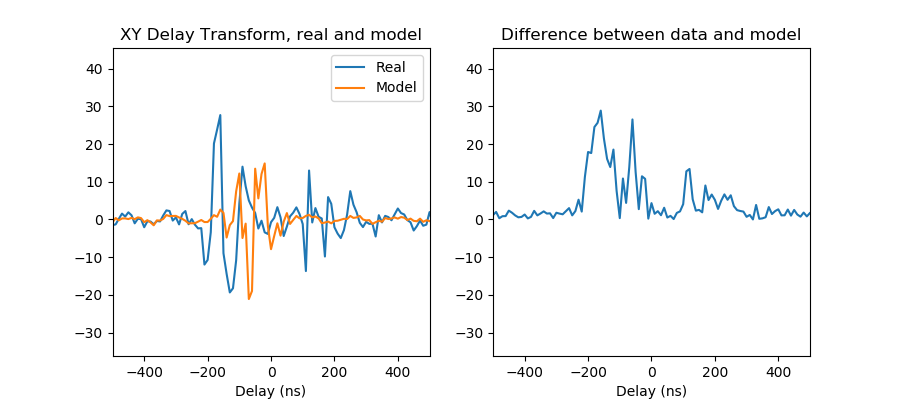

Text(0.5,1,'Difference between data and model')

In [15]:
#Plot
amp_factor = model_max / real_bl_max
print 'Antenna', antenna1, 'and', antenna2
print 'Amplitude correction factor:', amp_factor

#plt.figure(figsize=(9,4))
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_t),(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),(vis_avg_delay_xy)/amp_factor, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_xy, np.abs(np.abs(vis_avg_delay_t)-np.abs(vis_avg_delay_xy)/amp_factor))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')

In [18]:
ind_amp = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
ind_delays = np.zeros([len(ants),len(ants),2])
test_d = []
#Define constants for the beginning element that is within baseline 
#depenedence and the end element
blin_start = 400
blin_end = 542


for i,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[i]
    #print ant1,ant2
    #Flag out dead antennas
    if np.any(ant1==flagged_antennas) or np.any(ant2==flagged_antennas):
        ind_amp[i]=0
        ind_delays[ant_dict[ant1]][ant_dict[ant2]][0]=0
        ind_delays[ant_dict[ant1]][ant_dict[ant2]][1]=0
        continue

    # Create an array to hold the night's data
    spectrum = uvxy.data_array[i,0,:,0]
    # Fourier transform along the time axis
    vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
    #Find the frequency width of a channel in GHz
    freq_width = np.diff(uvxy.freq_array[0,:])[0]
    #Convert frequencies to delays and convert to ns
    con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))
    test_d = con_delays
    # Find the maximum amplitude and put into a variable
    peak_above_bl = np.max(np.abs(vis_avg_delay[:blin_start]))
    #print peak_above_bl
    peak_below_bl = np.max(np.abs(vis_avg_delay[blin_end:]))
    #print peak_below_bl
    #Find the corresponding delay
    delay_a = -con_delays[np.argwhere(np.abs(vis_avg_delay[:blin_start])==peak_above_bl)]
    #print np.argwhere(np.abs(vis_avg_delay[:blin_start])==peak_above_bl)
    delay_b = con_delays[np.argwhere(np.abs(vis_avg_delay[blin_end:])==peak_below_bl)]
    #print np.argwhere(np.abs(vis_avg_delay)==peak_below_bl)
    if delay_b.shape!=(1,1) or delay_a.shape!=(1,1):
        print ant1, ant2
        print delay_b.shape
        print delay_a.shape
    #Append the delay array with a list of the antenna pair and the delay
    ind_delays[ant_dict[ant1]][ant_dict[ant2]][1] = delay_a
    ind_delays[ant_dict[ant1]][ant_dict[ant2]][0] = delay_b

#Convert to numpy arrays
print 'Baseline independent delay array shape:', ind_delays.shape
print 'Baseline independent delay array mean:', np.mean(ind_delays)


Baseline independent delay array shape: (52, 52, 2)
Baseline independent delay array mean: -5.781675295857988e-07


In [19]:
test_d[400]*1e9

-1120.0

In [20]:
taus_c = np.mean(ind_delays,axis=1)

print taus_c.shape
print taus_c[ant_dict[antenna2],0]

(52, 2)
-2.011730769230769e-06


In [21]:
#'''
e_ci_a = np.e**((-1j) * np.pi * nu * taus_c[ant_dict[antenna1],1])
print e_ci_a
e_ci_b = np.e**((-1j) * np.pi * nu * taus_c[ant_dict[antenna1],0])
print e_ci_b

e_cj_a = np.e**((-1j) * np.pi * nu * taus_c[ant_dict[antenna2],1])
e_cj_b = np.e**((-1j) * np.pi * nu * taus_c[ant_dict[antenna2],0])

e_Ci = e_ci_a + e_ci_b
e_Cj = e_cj_a + e_cj_b

print e_Ci.shape
print e_Cj.shape

[[ 0.51733781+0.85578127j  0.63653437+0.77124833j  0.74213861+0.67024644j
  ... -0.79687176+0.6041485j  -0.70031614+0.71383282j
  -0.58880624+0.80827422j]]
[[ 0.51733781-0.85578127j  0.88891326-0.45807555j  0.99715869+0.07532963j
  ... -0.84393696+0.53644236j -0.99988771+0.01498525j
  -0.85963358-0.51091106j]]
(1, 1024)
(1, 1024)


In [22]:
'''
e_ci = np.e**((-1j) * np.pi * np.outer(taus_c[ant_dict[antenna1]],nu))
print e_ci.shape
print e_ci
e_cj = np.e**((-1j) * np.pi * np.outer(taus_c[ant_dict[antenna2]],nu))
print e_cj.shape
'''

'\ne_ci = np.e**((-1j) * np.pi * np.outer(taus_c[ant_dict[antenna1]],nu))\nprint e_ci.shape\nprint e_ci\ne_cj = np.e**((-1j) * np.pi * np.outer(taus_c[ant_dict[antenna2]],nu))\nprint e_cj.shape\n'

In [23]:
V_Cij = (V_Ri * e_Ci) + (V_Rj * e_Cj)

print np.mean(V_Cij)
print V_Cij.shape

(-0.0349597488479243+0.036073087435750315j)
(1, 1024)


In [24]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_vc = np.mean(V_Cij,axis=0)
vis_avg_delay_vc = np.mean(np.fft.fftshift(np.fft.fft(V_Cij,axis=1)),axis=0)
print vis_avg_delay_vc.shape
print np.mean(vis_avg_delay_vc)

model_maxvc = np.max(np.abs(vis_avg_delay_vc))
print model_maxvc
print delays_xy[np.argwhere(np.abs(vis_avg_delay_vc)==model_maxvc)] 


(1024,)
(2.248201624865942e-15-1.4710455076283324e-15j)
6372.225974872255
[[-220.]]


In [25]:
# 1) Fourier transform "vis_avg" along the freq axis
#vis_a = np.mean(e_ci_a,axis=0)
vis_avg_delay_a = np.mean(np.fft.fftshift(np.fft.fft(e_ci_a,axis=1)),axis=0)
print vis_avg_delay_a.shape
print np.mean(vis_avg_delay_a)

# 2) Find the frequency width of a channel in GHz
freq_width_a = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_a

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_a = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_a))*1e9
print delays_a.shape
print np.mean(delays_a)

model_maxa = np.max(np.abs(vis_avg_delay_a))
print model_maxa
print delays_a[np.argwhere(np.abs(vis_avg_delay_a)==model_maxa)] 

(1024,)
(0.5173378141776641+0.8557812723014429j)
97656.25
(1024,)
-5.0
979.5828201812852
[[-240.]]


In [26]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_b = np.mean(e_ci_b,axis=0)
vis_avg_delay_b = np.fft.fftshift(np.fft.fft(vis_b))
print vis_avg_delay_b.shape
print np.mean(vis_avg_delay_b)

# 2) Find the frequency width of a channel in GHz
freq_width_b = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_b

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_b = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_b))*1e9
print delays_b.shape
print np.mean(delays_b)

model_maxb = np.max(np.abs(vis_avg_delay_b))
print model_maxb
print delays_b[np.argwhere(np.abs(vis_avg_delay_b)==model_maxb)] 

(1024,)
(0.5173378141777597-0.8557812723013853j)
97656.25
(1024,)
-5.0
979.5828201812939
[[900.]]


Antenna 65 and 68
Ci a Amplitude correction factor: 23.09779620466229
Ci b Amplitude correction factor: 23.097796204662494
Vaij Amplitude correction factor: 150.25210110403566


<IPython.core.display.Javascript object>


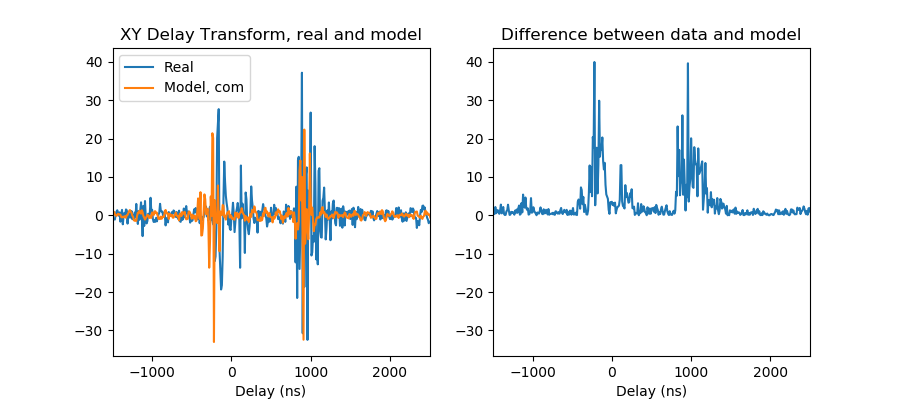

Text(0.5,1,'Difference between data and model')

In [34]:
#Plot
amp_factora = model_maxa / real_abs_max
amp_factorb = model_maxb / real_abs_max
amp_factorvc = model_maxvc / real_abs_max
print 'Antenna', antenna1, 'and', antenna2
print 'Ci a Amplitude correction factor:', amp_factora
print 'Ci b Amplitude correction factor:', amp_factorb
print 'Vaij Amplitude correction factor:', amp_factorvc

#plt.figure(figsize=(9,4))
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_t),(vis_avg_delay_t), label='Real')
#plt.plot((delays_a),np.abs(vis_avg_delay_a)/amp_factora, label='Model, b')
#plt.plot((delays_b),np.abs(vis_avg_delay_b)/amp_factorb,label='Model, a')
plt.plot((delays_xy),(vis_avg_delay_vc)/amp_factorvc, label='Model, com')
plt.xlabel('Delay (ns)')
plt.xlim(-1500,2500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_xy, np.abs(np.abs(vis_avg_delay_t)-(np.abs(vis_avg_delay_vc)/amp_factorvc)))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')

In [36]:
#modelx = x + V_Rij
model = V_Cij + V_Rij

In [37]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_mod = np.mean(model,axis=0)
vis_avg_delay_mod = np.fft.fftshift(np.fft.fft(vis_mod))
print vis_avg_delay_mod.shape
print np.mean(vis_avg_delay_mod)

model_maxmod = np.max(np.abs(vis_avg_delay_mod))
print model_maxmod
print delays_xy[np.argwhere(np.abs(vis_avg_delay_mod)==model_maxmod)] 

(1024,)
(-4.440892098500626e-16-2.7755575615628914e-15j)
6429.990459666728
[[-220.]]


Antenna 65 and 68
Amplitude correction factor: 151.61414244465772


<IPython.core.display.Javascript object>


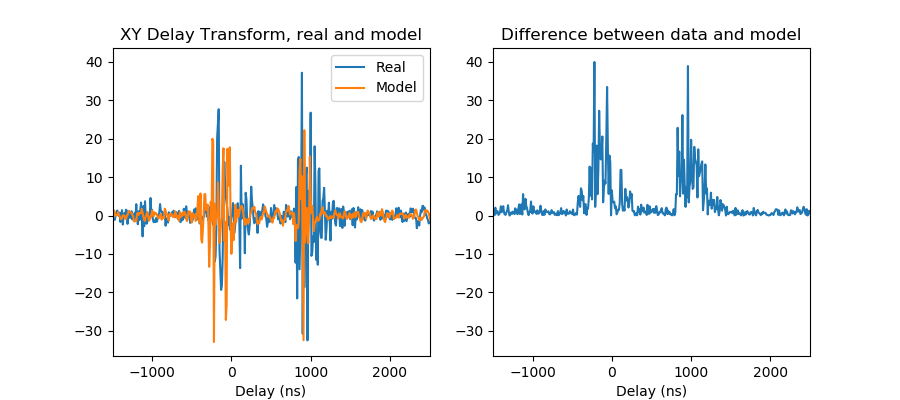

Text(0.5,1,'Difference between data and model')

In [40]:
#Plot
amp_factor_mod = model_maxmod / real_abs_max
print 'Antenna', antenna1, 'and', antenna2
print 'Amplitude correction factor:', amp_factor_mod

#plt.figure(figsize=(9,4))
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_t),(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),(vis_avg_delay_mod)/amp_factor_mod, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-1500,2500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_xy, np.abs(np.abs(vis_avg_delay_t)-np.abs(vis_avg_delay_mod)/amp_factor_mod))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')

In [36]:
print V_k.shape
testing = np.sum(V_k/52.,axis=1)
testing = testing[:,None]
print testing.shape

plt.figure()

plt.imshow(np.abs(testing),norm=SymLogNorm(vmin=0,vmax=5,linthresh=.1))
#plt.yticks(np.arange(len(uvxy.antenna_numbers)), uvxy.antenna_numbers, rotation='horizontal', fontsize=8)
plt.xticks([])
plt.title('Amplitudes averaged \nacross antennas')

(52, 1024)
(52, 1)
